<a href="https://colab.research.google.com/github/venkatanadikatla/pytorch/blob/main/Hierarchical_Model_Energy_Efficient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dataset Information**

https://archive.ics.uci.edu/dataset/242/energy+efficiency

We perform energy analysis using 12 different building shapes simulated in Ecotect. The buildings differ with respect to the glazing area, the glazing area distribution, and the orientation, amongst other parameters. We simulate various settings as functions of the afore-mentioned characteristics to obtain 768 building shapes. The dataset comprises 768 samples and 8 features, aiming to predict two real valued responses. It can also be used as a multi-class classification problem if the response is rounded to the nearest integer.

However, for this project - My aim to predict **heating Load** and use the "**Hierarchical Bayesian Model**"

**Additional Variable Information**
The dataset contains eight attributes (or features, denoted by X1...X8) and two responses (or outcomes, denoted by y1 and y2). The aim is to use the eight features to predict each of the two responses.

**Specifically:**

**X1	Relative Compactness**

**X2	Surface Area**

**X3	Wall Area**

**X4	Roof Area**

**X5	Overall Height**

**X6	Orientation**

**X7	Glazing Area**

**X8	Glazing Area Distribution**

**y1	Heating Load**

**y2	Cooling Load**

**License**

This dataset is licensed under a Creative Commons Attribution 4.0 International (CC BY 4.0) license.https://creativecommons.org/licenses/by/4.0/legalcode

This allows for the sharing and adaptation of the datasets for any purpose, provided that the appropriate credit is given.

In [ ]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"
df = pd.read_excel(url)
df.columns = ['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 'Overall_Height',
              'Orientation', 'Glazing_Area', 'Glazing_Area_Distribution', 'Heating_Load', 'Cooling_Load']

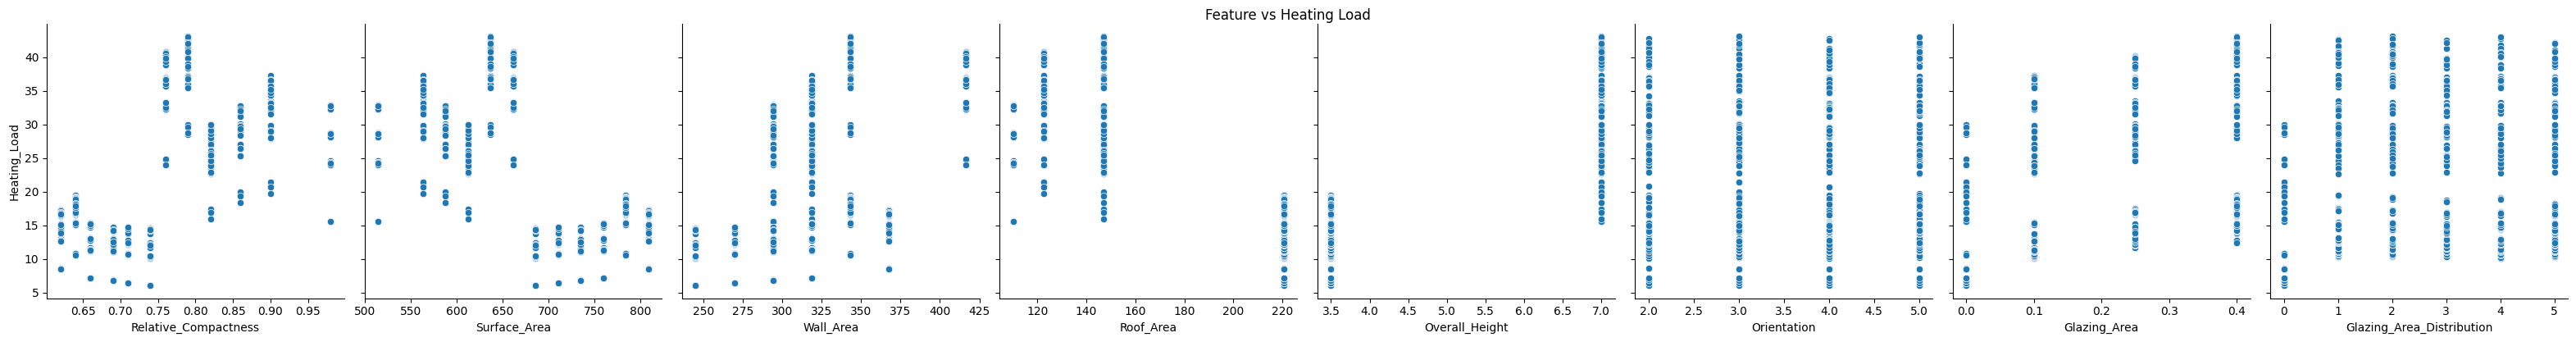

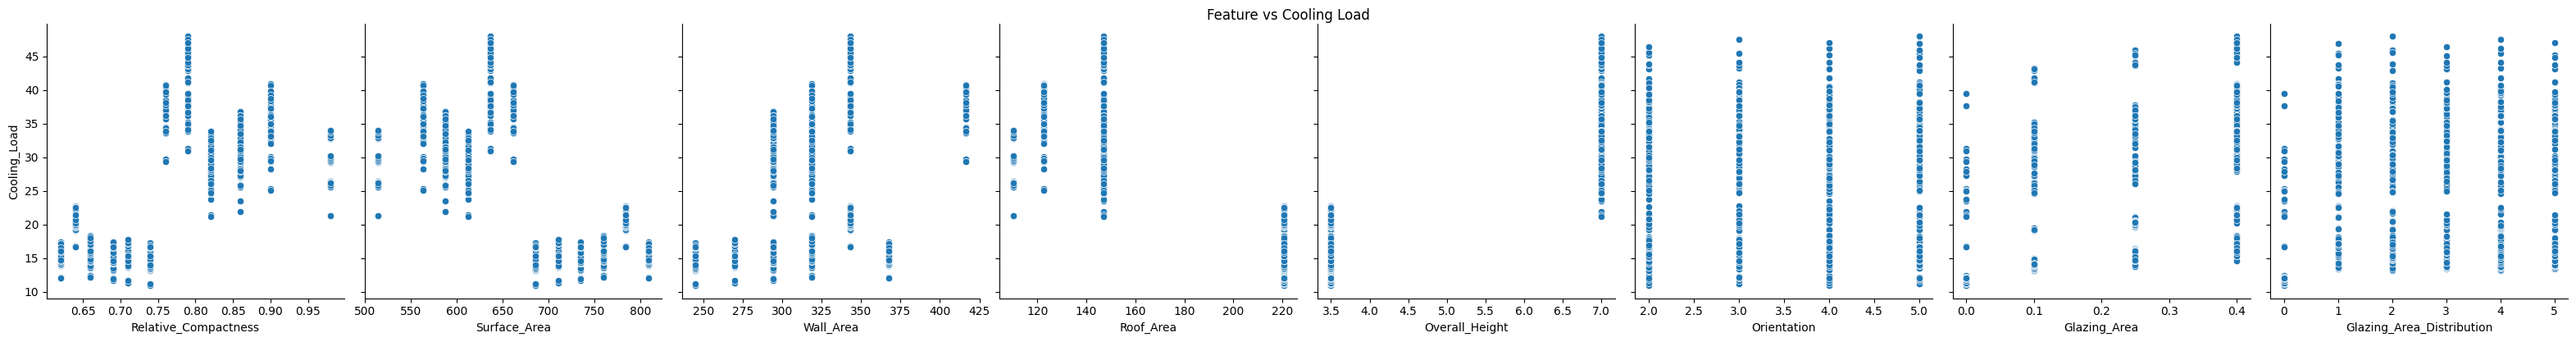

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pairplot to check linearity for heating load
sns.pairplot(df, x_vars=['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 'Overall_Height',
              'Orientation', 'Glazing_Area', 'Glazing_Area_Distribution'],
             y_vars='Heating_Load', height=4, aspect=1)
plt.suptitle('Feature vs Heating Load', y=1.02)
plt.show()

# Pairplot for cooling load
sns.pairplot(df, x_vars=['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 'Overall_Height',
              'Orientation', 'Glazing_Area', 'Glazing_Area_Distribution'],
             y_vars='Cooling_Load', height=4, aspect=1)
plt.suptitle('Feature vs Cooling Load', y=1.02)
plt.show()


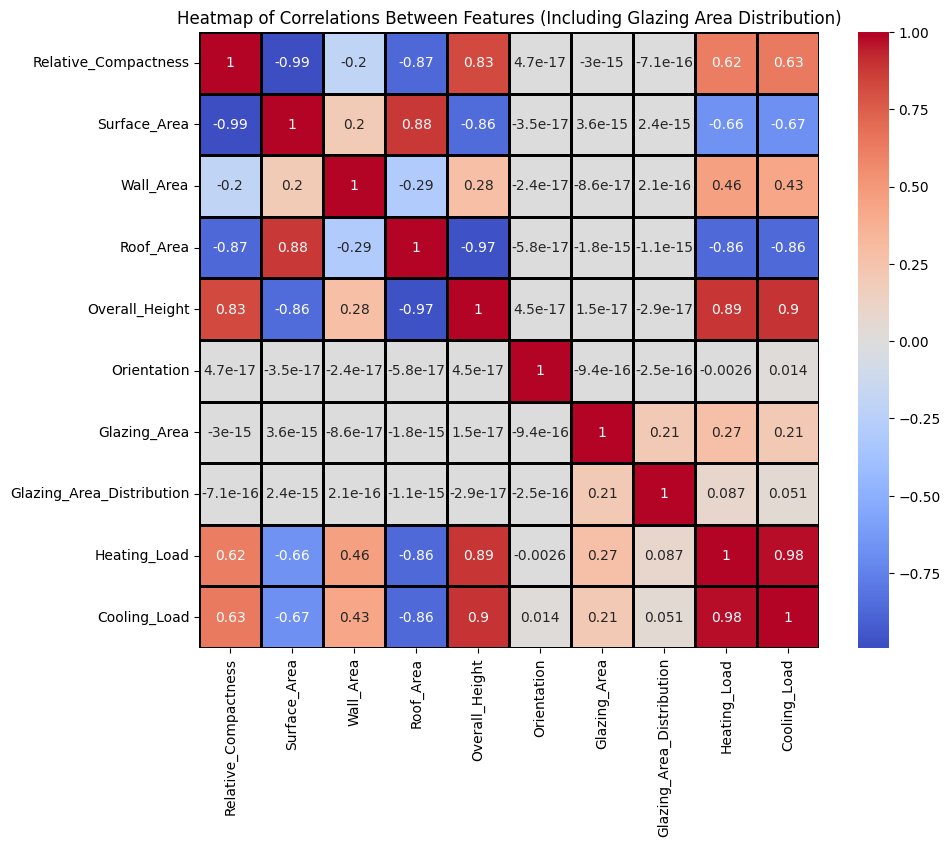

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Selecting relevant features for heatmap (including interactions)
interaction_features = ['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 'Overall_Height',
              'Orientation', 'Glazing_Area', 'Glazing_Area_Distribution', 'Heating_Load', 'Cooling_Load']

# Create a new dataframe with these features
df_interaction = df[interaction_features]

# Generate the correlation matrix
corr_matrix_interaction = df_interaction.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_interaction, annot=True, cmap="coolwarm", center=0, linewidths=1, linecolor='black')
plt.title('Heatmap of Correlations Between Features (Including Glazing Area Distribution)')
plt.show()


In [ ]:
# Correlation matrix for heating load
corr_matrix_heating = df.corr()['Heating_Load']
print(corr_matrix_heating)

# Correlation matrix for cooling load
corr_matrix_cooling = df.corr()['Cooling_Load']
print(corr_matrix_cooling)


Relative_Compactness         0.622272
Surface_Area                -0.658120
Wall_Area                    0.455671
Roof_Area                   -0.861828
Overall_Height               0.889430
Orientation                 -0.002587
Glazing_Area                 0.269842
Glazing_Area_Distribution    0.087368
Heating_Load                 1.000000
Cooling_Load                 0.975862
Name: Heating_Load, dtype: float64
Relative_Compactness         0.634339
Surface_Area                -0.672999
Wall_Area                    0.427117
Roof_Area                   -0.862547
Overall_Height               0.895785
Orientation                  0.014290
Glazing_Area                 0.207505
Glazing_Area_Distribution    0.050525
Heating_Load                 0.975862
Cooling_Load                 1.000000
Name: Cooling_Load, dtype: float64


In [ ]:

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler


# Select only the feature columns (exclude the target variable)
X = df[['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 'Overall_Height', 'Orientation',
        'Glazing_Area', 'Glazing_Area_Distribution']]

# Standardize the features (optional but recommended to get better VIF results)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a DataFrame for scaled features
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_scaled_df.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled_df.values, i) for i in range(X_scaled_df.shape[1])]

# Print the VIF results
print(vif_data)


                     Feature         VIF
0       Relative_Compactness  105.524054
1               Surface_Area         inf
2                  Wall_Area         inf
3                  Roof_Area         inf
4             Overall_Height   31.205474
5                Orientation    1.000000
6               Glazing_Area    1.047508
7  Glazing_Area_Distribution    1.047508


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


**Mulitcollinearity**:

Since multicollinearity can distort the interpretation of this model, I want to remove some of the highly correlated features.
 * Remove features like Relative Compactness, Roof Area, and Surface Area, and keep only Overall Height (since it has the highest correlation with my target).

 Note: Alternatively, I can also use Principal Compoenent Analysis (PCA) to avoid multicollinearity but I am going to remove the features on this model instead of using PCA.

In [ ]:
df = df.drop(['Relative_Compactness','Roof_Area','Surface_Area'], axis=1)
df.head()
df.columns

Index(['Wall_Area', 'Overall_Height', 'Orientation', 'Glazing_Area',
       'Glazing_Area_Distribution', 'Heating_Load', 'Cooling_Load'],
      dtype='object')

**Simple Linear Regression without the Hierarchical Model**:

Below model is using sklearn's LinearRegression, which implements ordinary least squares linear regression. This is a basic linear model without any hierarchical structure

RMSE for Heating Load: 9.068626297706798


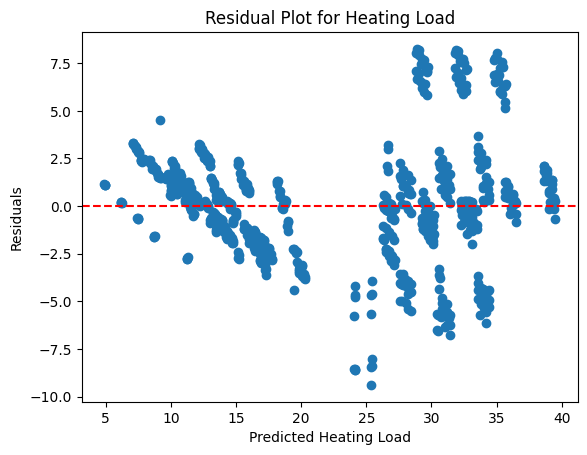

In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Define features and target for heating load
X = df[['Wall_Area', 'Overall_Height', 'Orientation', 'Glazing_Area',
       'Glazing_Area_Distribution']]
y_heating = df['Heating_Load']

# Fit linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X, y_heating)
y_pred = lin_reg.predict(X)

# Calculate residuals
residuals = y_heating - y_pred
# Optionally, calculate the RMSE
rmse_log = mean_squared_error(y_heating, y_pred)
print("RMSE for Heating Load:", rmse_log)

# Plot residuals
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot for Heating Load')
plt.xlabel('Predicted Heating Load')
plt.ylabel('Residuals')
plt.show()


**Hierarchical Bayesian Modeling for Predicting Heating Load with Non-Linear Relationships**

In this analysis, I aim to predict Heating Load by accounting for non-linear relationships between the input features and the target variable. To capture these complexities, I employ a Hierarchical Bayesian model, incorporating both linear and quadratic (polynomial) terms to model non-linear patterns effectively.

The hierarchical structure allows us to account for variations in heating load across different Glazing Area Distributions, modeling both individual and group-level effects. This approach enhances prediction accuracy while providing a more interpretable framework for understanding how the features influence Heating Load.

**Model1**: **Bayesian Hierarchical Model with Polynomial Approach (Centered Parametrization)**

This model implements a Bayesian Hierarchical approach to predict Heating Load using both linear and quadratic (polynomial) terms to account for non-linear relationships in the input features. The hierarchical structure incorporates group-level effects, with glazing area distribution as the grouping factor. I use a centered parametrization where the group-level parameters (for each glazing area distribution) are modeled with Gamma distributions, while the individual-level coefficients for linear and quadratic terms are given Normal priors.

Posterior sampling is performed using PyMC, followed by convergence diagnostics and posterior predictive checks to assess model fit and performance.

Output()

Output()

Output()

Output()

                   mean       sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
alpha           241.279  375.215     0.329    883.085      9.024    6.382   
beta             14.012   15.466     0.130     42.393      0.346    0.245   
beta_linear[0]    2.141    0.116     1.918      2.372      0.001    0.001   
beta_linear[1]    8.372    0.110     8.164      8.589      0.001    0.001   
beta_linear[2]    1.021    7.036   -13.050     14.875      0.111    0.078   
beta_linear[3]   -0.028    0.104    -0.234      0.174      0.001    0.001   
beta_linear[4]    1.234    7.038   -12.514     15.365      0.111    0.078   
beta_linear[5]    0.518    0.596    -0.609      1.802      0.010    0.007   
beta_quad[0]      0.198    0.078     0.048      0.355      0.001    0.001   
beta_quad[1]      9.110    6.954    -4.403     21.082      0.261    0.200   
beta_quad[2]      0.028    7.109   -13.927     13.966      0.115    0.081   
beta_quad[3]     -0.014    0.128    -0.263      0.243      0.001    0.001   

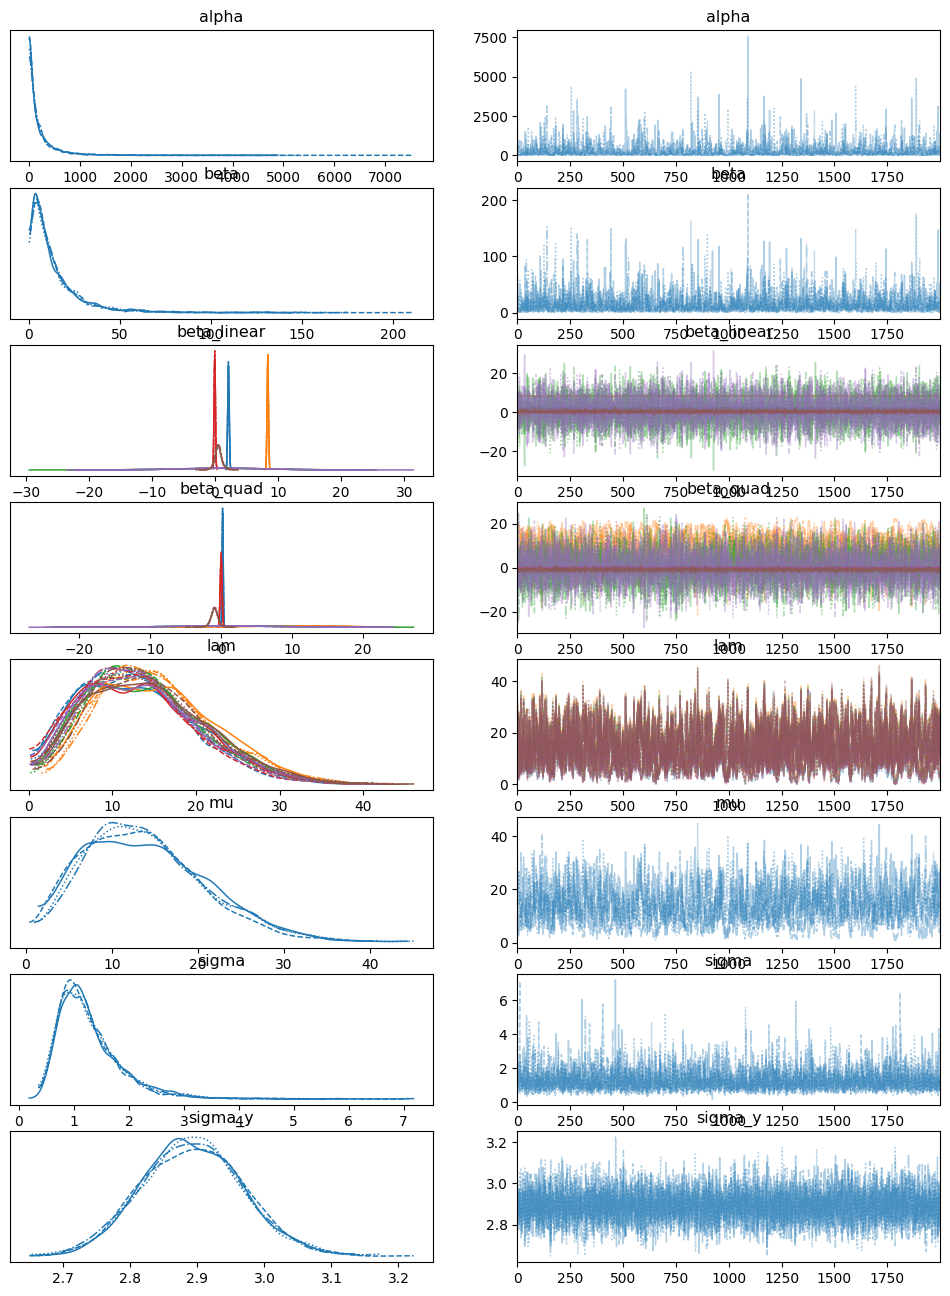

Output()

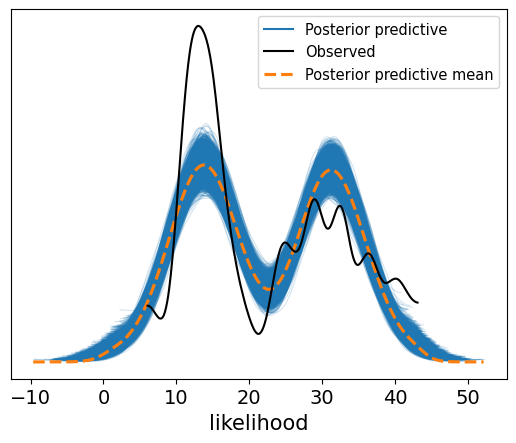

<xarray.Dataset> Size: 328B
Dimensions:            (beta_linear_dim_0: 6, beta_quad_dim_0: 6,
                        glazing_area: 6)
Coordinates:
  * beta_linear_dim_0  (beta_linear_dim_0) int64 48B 0 1 2 3 4 5
  * beta_quad_dim_0    (beta_quad_dim_0) int64 48B 0 1 2 3 4 5
  * glazing_area       (glazing_area) int64 48B 0 1 2 3 4 5
Data variables:
    alpha              float64 8B 1.003
    beta               float64 8B 1.003
    beta_linear        (beta_linear_dim_0) float64 48B 1.0 1.0 ... 1.001 1.001
    beta_quad          (beta_quad_dim_0) float64 48B 1.0 1.003 ... 1.001 1.001
    lam                (glazing_area) float64 48B 1.003 1.003 ... 1.003 1.003
    mu                 float64 8B 1.003
    sigma              float64 8B 1.001
    sigma_y            float64 8B 1.0


In [ ]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"
df = pd.read_excel(url)

# Rename the columns for easier reference
df.columns = ['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 'Overall_Height',
              'Orientation', 'Glazing_Area', 'Glazing_Area_Distribution', 'Heating_Load', 'Cooling_Load']

# Standardize the input variables for better performance in the Bayesian model
X = df[[ 'Wall_Area', 'Overall_Height', 'Glazing_Area', 'Orientation', 'Glazing_Area',
       'Glazing_Area_Distribution' ]]

X_standardized = (X - X.mean()) / X.std()

# Add polynomial terms (squared) to capture non-linear relationships
X_squared = X_standardized**2  # Adding squared terms for non-linearity

# Define the response variable (Heating Load)
y = df['Heating_Load']

# Group by Glazing Area Distribution (zero-indexed)
group_zero_indexed = df['Glazing_Area_Distribution']  # Assuming values are 0 to 5

# Define coordinates for PyMC
COORDS = {
    'obs': df.index,
    'glazing_area': df['Glazing_Area_Distribution'].unique()
}

# Hierarchical Bayesian Model Setup with Polynomial Terms
with pm.Model(coords=COORDS) as hierarchical_model:
    # Hyperpriors: Priors for the group-level parameters (for glazing area distribution)
    mu = pm.Gamma('mu', alpha=2.0, beta=1.0/5)  # Prior for group-level mean (mu)
    sigma = pm.Exponential('sigma', 1.0)  # Prior for group-level variance (sigma)

    # Parametrization for Gamma distribution
    alpha = pm.Deterministic('alpha', mu**2 / sigma**2)
    beta = pm.Deterministic('beta', mu / sigma**2)

    # Gamma prior for the group-level parameters (for each glazing area distribution)
    lam = pm.Gamma('lam', alpha=alpha, beta=beta, dims='glazing_area')

    # Priors for individual-level coefficients (for linear and quadratic terms)
    beta_linear = pm.Normal('beta_linear', mu=0, sigma=10, shape=X_standardized.shape[1])
    beta_quad = pm.Normal('beta_quad', mu=0, sigma=10, shape=X_squared.shape[1])

    # Noise term
    sigma_y = pm.HalfNormal('sigma_y', sigma=10)

    # Linear + quadratic model for heating load (group-level + individual-level effects)
    mu_y = lam[group_zero_indexed] + pm.math.dot(X_standardized, beta_linear) + pm.math.dot(X_squared, beta_quad)

    # Likelihood for heating load
    likelihood = pm.Normal('likelihood', mu=mu_y, sigma=sigma_y, observed=y, dims='obs')

    # Sample from the posterior
    trace = pm.sample(2000, tune=3000, chains=4, target_accept=0.95, return_inferencedata=True)

# Summarize the posterior distributions
summary = az.summary(trace, hdi_prob=0.95)
print(summary)

# Plot the trace to visually inspect the model's convergence
az.plot_trace(trace)
plt.show()
az.summary(trace, hdi_prob=0.95)

# Posterior Predictive Check
with hierarchical_model:
    ppc = pm.sample_posterior_predictive(trace, return_inferencedata=True)

# No need for from_pymc or from_pymc3
# 'ppc' already contains posterior predictive data in the InferenceData format

# Plot posterior predictive checks directly using ArviZ
az.plot_ppc(ppc)
plt.show()

# Get and display the R-hat statistics (to check for convergence)
rhat_values = az.rhat(trace)
print(rhat_values)

In [ ]:
# Posterior Predictive Check
with hierarchical_model:
    ppc = pm.sample_posterior_predictive(trace, return_inferencedata=False)

# Extract the predicted values for the target variable (Heating Load)
predicted_heating_load = ppc['likelihood']

# Flatten the posterior predictive samples (combine chains and samples)
# Shape will become (4000, 768) after combining chains and samples
predicted_heating_load_flat = predicted_heating_load.reshape(-1, predicted_heating_load.shape[-1])

# Convert the 2D array into a pandas DataFrame
predicted_heating_load_df = pd.DataFrame(predicted_heating_load_flat)

# View summary statistics of the predictions
mean_predictions = predicted_heating_load_df.mean(axis=0)  # Mean of the posterior predictions
median_predictions = predicted_heating_load_df.median(axis=0)  # Median of the posterior predictions
lower_bound = predicted_heating_load_df.quantile(0.025, axis=0)  # Lower bound of 95% credible interval
upper_bound = predicted_heating_load_df.quantile(0.975, axis=0)  # Upper bound of 95% credible interval

# Print the summary statistics
print("Mean Predictions:\n", mean_predictions)
print("Median Predictions:\n", median_predictions)
print("95% Credible Interval (Lower Bound):\n", lower_bound)
print("95% Credible Interval (Upper Bound):\n", upper_bound)


Output()

Mean Predictions:
 0      21.447716
1      21.474770
2      21.430314
3      21.379506
4      22.610906
         ...    
763    17.873078
764    19.370281
765    19.342094
766    19.346540
767    19.282135
Length: 768, dtype: float64
Median Predictions:
 0      21.431132
1      21.492582
2      21.463448
3      21.354799
4      22.618383
         ...    
763    17.872767
764    19.350453
765    19.365814
766    19.391244
767    19.267960
Length: 768, dtype: float64
95% Credible Interval (Lower Bound):
 0      15.651782
1      15.774861
2      15.680879
3      15.733933
4      16.620527
         ...    
763    12.215990
764    13.711513
765    13.551078
766    13.659934
767    13.591026
Name: 0.025, Length: 768, dtype: float64
95% Credible Interval (Upper Bound):
 0      27.140536
1      27.149059
2      27.254135
3      27.008606
4      28.462139
         ...    
763    23.576174
764    25.085918
765    25.058576
766    25.008927
767    24.958113
Name: 0.975, Length: 768, dtype: float6

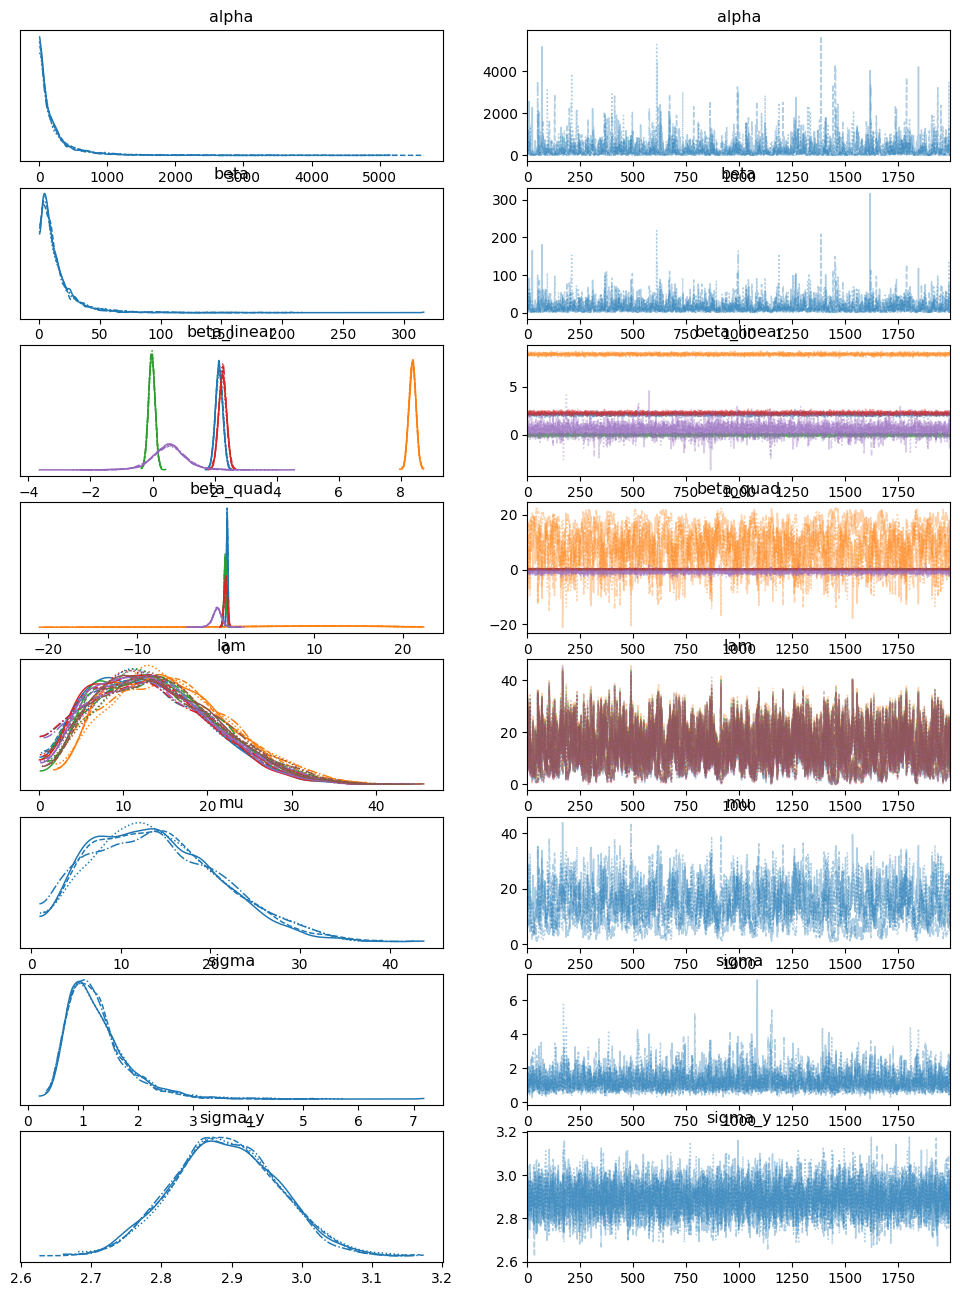

<xarray.Dataset> Size: 296B
Dimensions:            (beta_linear_dim_0: 5, beta_quad_dim_0: 5,
                        glazing_area: 6)
Coordinates:
  * beta_linear_dim_0  (beta_linear_dim_0) int64 40B 0 1 2 3 4
  * beta_quad_dim_0    (beta_quad_dim_0) int64 40B 0 1 2 3 4
  * glazing_area       (glazing_area) int64 48B 0 1 2 3 4 5
Data variables:
    alpha              float64 8B 1.004
    beta               float64 8B 1.003
    beta_linear        (beta_linear_dim_0) float64 40B 1.001 1.0 1.0 1.001 1.0
    beta_quad          (beta_quad_dim_0) float64 40B 1.001 1.003 ... 1.0 1.001
    lam                (glazing_area) float64 48B 1.003 1.003 ... 1.003 1.003
    mu                 float64 8B 1.003
    sigma              float64 8B 1.001
    sigma_y            float64 8B 1.0


In [ ]:
# Plot the trace to visually inspect the model's convergence
az.plot_trace(trace)
plt.show()

# Get and display the R-hat statistics (to check for convergence)
rhat_values = az.rhat(trace)
print(rhat_values)



**Model 2: Hierarchical Bayesian Modeling for Predicting Heating Load with Non-Linear Relationships and Interaction Terms**

In this model, I extend the Hierarchical Bayesian framework by incorporating non-linear relationships along with an interaction term between Wall Area and Glazing Area. This interaction term is created by multiplying the standardized values of these two variables to capture their combined effect on Heating Load.

The hierarchical structure continues to account for group-level variations based on Glazing Area Distribution, and I retain both linear and quadratic (polynomial) terms in the model. This enables us to better capture the complexities of the data and improve predictive accuracy.

In Model 3, I will further extend this approach by introducing an interaction term between Overall height and wall area.

**Note:** To avoid overfitting, the individual features involved in interaction terms (Wall Area and Glazing Area) have been removed from the model. This ensures that the model remains robust without introducing unnecessary complexity.

Output()

Output()

Output()

Output()

                    mean       sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
alpha             77.816  104.534     0.053    268.244      2.857    2.021   
beta               4.519    4.106     0.083     12.314      0.113    0.080   
beta_interaction   0.260    0.152    -0.033      0.553      0.001    0.001   
beta_linear[0]     8.974    0.151     8.693      9.274      0.001    0.001   
beta_linear[1]    -0.027    0.151    -0.339      0.259      0.002    0.002   
beta_linear[2]     1.163    0.910    -0.762      2.918      0.015    0.011   
beta_quad[0]      10.322    7.175    -2.357     23.156      0.304    0.258   
beta_quad[1]      -0.012    0.187    -0.363      0.370      0.002    0.002   
beta_quad[2]      -1.849    0.809    -3.428     -0.187      0.012    0.009   
lam[0]            12.338    7.254     0.000     25.211      0.302    0.214   
lam[1]            16.515    7.124     3.836     29.427      0.301    0.213   
lam[2]            13.741    7.166     1.110     26.836      0.30

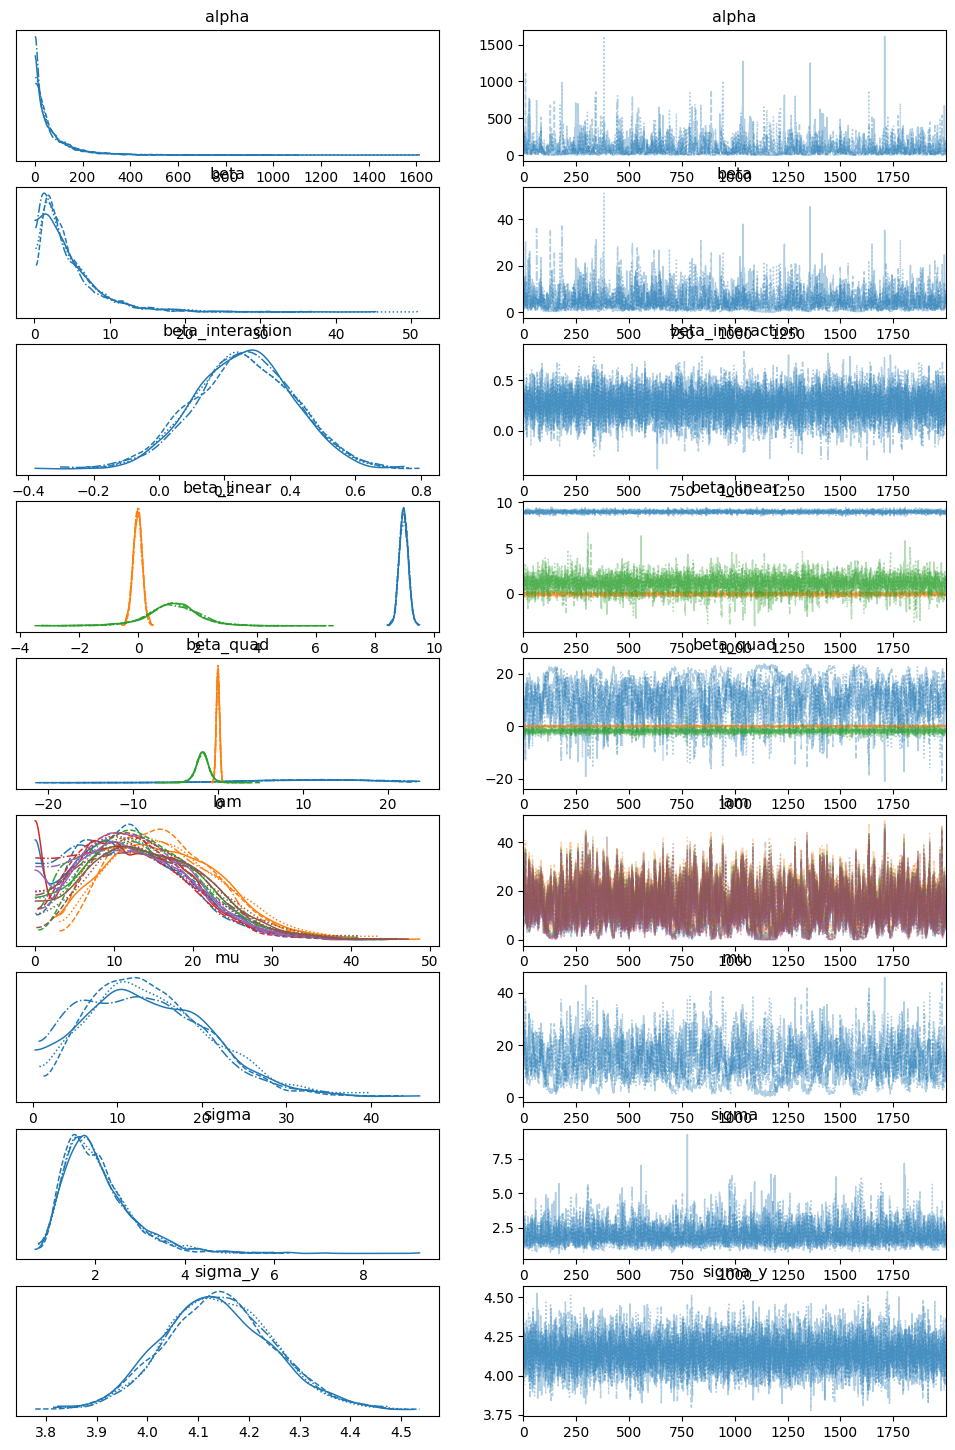

Output()

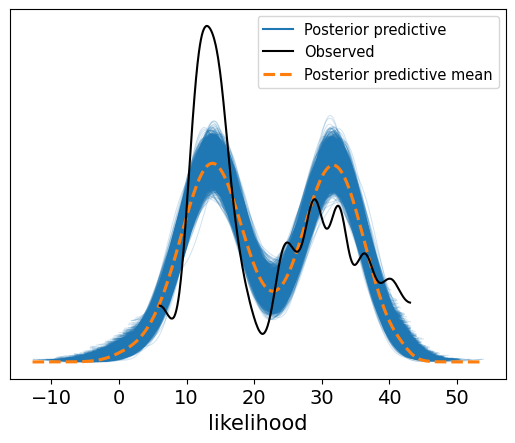

In [ ]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"
df = pd.read_excel(url)

# Rename the columns for easier reference
df.columns = ['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 'Overall_Height',
              'Orientation', 'Glazing_Area', 'Glazing_Area_Distribution', 'Heating_Load', 'Cooling_Load']

# Standardize the input variables for better performance in the Bayesian model
X = df[['Overall_Height', 'Orientation', 'Glazing_Area_Distribution']]

X_standardized = (X - X.mean()) / X.std()

# Add polynomial terms (squared) to capture non-linear relationships
X_squared = X_standardized**2  # Adding squared terms for non-linearity


# Add interaction term for Wall_Area and Glazing_Area
# Add interaction term for Wall_Area and Glazing_Area (use already standardized variables)
X_interaction = (df['Wall_Area'] - df['Wall_Area'].mean()) / df['Wall_Area'].std() * \
                (df['Glazing_Area'] - df['Glazing_Area'].mean()) / df['Glazing_Area'].std()
X_combined = pd.concat([X_standardized, X_squared, X_interaction.rename('Wall_Glazing_Interaction')], axis=1)

# Define the response variable (Heating Load)
y = df['Heating_Load']

# Group by Glazing Area Distribution (zero-indexed)
group_zero_indexed = df['Glazing_Area_Distribution']

# Define coordinates for PyMC
COORDS = {
    'obs': df.index,
    'glazing_area': df['Glazing_Area_Distribution'].unique()
}

# Hierarchical Bayesian Model Setup with Polynomial and Interaction Terms
with pm.Model(coords=COORDS) as hierarchical_model:
    # Hyperpriors for the group-level parameters (for glazing area distribution)
    mu = pm.Gamma('mu', alpha=2.0, beta=1.0/5)  # Prior for group-level mean (mu)
    sigma = pm.Exponential('sigma', 1.0)  # Prior for group-level variance (sigma)

    # Parametrization for Gamma distribution
    alpha = pm.Deterministic('alpha', mu**2 / sigma**2)
    beta = pm.Deterministic('beta', mu / sigma**2)

    # Gamma prior for the group-level parameters (for each glazing area distribution)
    lam = pm.Gamma('lam', alpha=alpha, beta=beta, dims='glazing_area')

    # Priors for individual-level coefficients (for linear, quadratic, and interaction terms)
    beta_linear = pm.Normal('beta_linear', mu=0, sigma=10, shape=X_standardized.shape[1])
    beta_quad = pm.Normal('beta_quad', mu=0, sigma=10, shape=X_squared.shape[1])
    beta_interaction = pm.Normal('beta_interaction', mu=0, sigma=10)  # Interaction term coefficient

    # Noise term
    sigma_y = pm.HalfNormal('sigma_y', sigma=10)

    # Linear + quadratic + interaction model for heating load (group-level + individual-level effects)
    mu_y = (
        lam[group_zero_indexed] +
        pm.math.dot(X_standardized, beta_linear) +
        pm.math.dot(X_squared, beta_quad) +
        beta_interaction * X_interaction
    )

    # Likelihood for heating load
    likelihood = pm.Normal('likelihood', mu=mu_y, sigma=sigma_y, observed=y, dims='obs')

    # Sample from the posterior
    trace = pm.sample(2000, tune=3000, chains=4, target_accept=0.99, return_inferencedata=True)

# Summarize the posterior distributions
summary = az.summary(trace, hdi_prob=0.95)
print(summary)

# Trace plot for checking convergence
az.plot_trace(trace)
plt.show()

# Posterior Predictive Check
with hierarchical_model:
    ppc = pm.sample_posterior_predictive(trace, return_inferencedata=True)

# Plot posterior predictive checks directly using ArviZ
az.plot_ppc(ppc)
plt.show()


In [ ]:

# Get and display the R-hat statistics (to check for convergence)
rhat_values = az.rhat(trace)
print(rhat_values)



<xarray.Dataset> Size: 240B
Dimensions:            (beta_linear_dim_0: 3, beta_quad_dim_0: 3,
                        glazing_area: 6)
Coordinates:
  * beta_linear_dim_0  (beta_linear_dim_0) int64 24B 0 1 2
  * beta_quad_dim_0    (beta_quad_dim_0) int64 24B 0 1 2
  * glazing_area       (glazing_area) int64 48B 0 1 2 3 4 5
Data variables:
    alpha              float64 8B 1.008
    beta               float64 8B 1.008
    beta_interaction   float64 8B 1.001
    beta_linear        (beta_linear_dim_0) float64 24B 1.0 1.0 1.002
    beta_quad          (beta_quad_dim_0) float64 24B 1.007 1.0 1.001
    lam                (glazing_area) float64 48B 1.007 1.007 ... 1.007 1.006
    mu                 float64 8B 1.007
    sigma              float64 8B 1.002
    sigma_y            float64 8B 1.0


**Model 3: Hierarchical Bayesian Modeling for Predicting Heating Load with Non-Linear Relationships and Interaction Terms (non-centered parameterization)**

In this model, I extend the Hierarchical Bayesian framework by incorporating non-linear relationships along with an interaction term between Overall Height and Wall Area. This interaction term is created by multiplying the standardized values of these two variables to capture their combined effect on Heating Load.

The hierarchical structure, implemented using a **non-centered parameterization**, continues to account for group-level variations based on Glazing Area Distribution, and I retain both linear and quadratic (polynomial) terms in the model. The non-centered parameterization helps improve sampling efficiency and convergence, especially in hierarchical models.

Note: To avoid overfitting, the individual features involved in the interaction term (Overall Height and Wall Area) have been removed from the model. This ensures that the model remains robust without introducing unnecessary complexity.

Output()

Output()

Output()

Output()

Output()

Output()

                    mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
beta_interaction   0.986  0.365     0.295      1.712      0.003    0.002   
beta_linear[0]    -0.027  0.349    -0.723      0.624      0.003    0.003   
beta_linear[1]     2.253  0.418     1.441      3.049      0.004    0.003   
beta_linear[2]     2.456  2.042    -1.450      6.511      0.025    0.019   
beta_quad[0]       0.321  0.432    -0.513      1.176      0.004    0.003   
beta_quad[1]       0.395  0.598    -0.754      1.586      0.006    0.005   
beta_quad[2]       6.928  1.447     3.999      9.671      0.017    0.012   
mu[0]             -1.411  4.484   -10.244      7.297      0.051    0.041   
mu[1]             14.982  2.488     9.994     19.701      0.029    0.021   
mu[2]             20.715  1.355    18.123     23.461      0.014    0.010   
mu[3]             20.683  1.068    18.598     22.799      0.010    0.007   
mu[4]             15.467  2.172    11.320     19.794      0.026    0.018   
mu[5]       

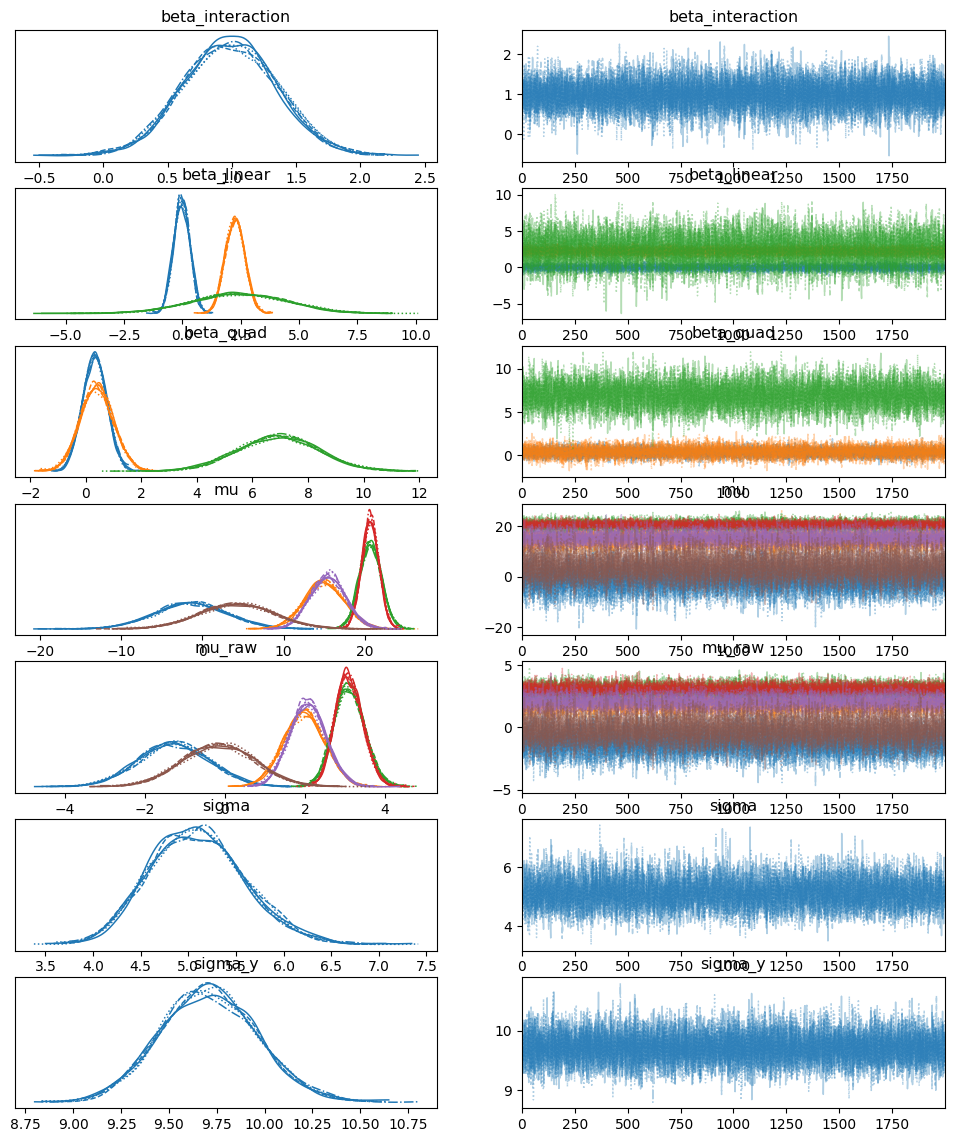

Output()

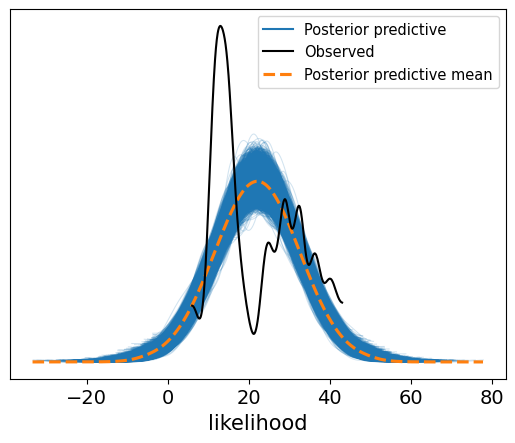

<xarray.Dataset> Size: 312B
Dimensions:            (beta_linear_dim_0: 3, beta_quad_dim_0: 3, mu_dim_0: 6,
                        glazing_area: 6)
Coordinates:
  * beta_linear_dim_0  (beta_linear_dim_0) int64 24B 0 1 2
  * beta_quad_dim_0    (beta_quad_dim_0) int64 24B 0 1 2
  * mu_dim_0           (mu_dim_0) int64 48B 0 1 2 3 4 5
  * glazing_area       (glazing_area) int64 48B 0 1 2 3 4 5
Data variables:
    beta_interaction   float64 8B 1.001
    beta_linear        (beta_linear_dim_0) float64 24B 1.001 1.0 1.0
    beta_quad          (beta_quad_dim_0) float64 24B 0.9998 1.0 1.001
    mu                 (mu_dim_0) float64 48B 1.0 1.0 0.9999 1.0 1.001 1.0
    mu_raw             (glazing_area) float64 48B 1.0 1.0 1.0 1.0 1.001 1.0
    sigma              float64 8B 1.001
    sigma_y            float64 8B 1.001


In [ ]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"
df = pd.read_excel(url)

# Rename the columns for easier reference
df.columns = ['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 'Overall_Height',
              'Orientation', 'Glazing_Area', 'Glazing_Area_Distribution', 'Heating_Load', 'Cooling_Load']

# Standardize the input variables for better performance in the Bayesian model
X = df[['Orientation', 'Glazing_Area', 'Glazing_Area_Distribution']]  # Exclude Overall_Height and Wall_Area here to use them in interaction
X_standardized = (X - X.mean()) / X.std()

# Add polynomial terms (squared) to capture non-linear relationships
X_squared = X_standardized**2  # Adding squared terms for non-linearity

# Add interaction term for Overall_Height and Wall_Area (use already standardized variables)
X_interaction = (df['Overall_Height'] - df['Overall_Height'].mean()) / df['Overall_Height'].std() * \
                (df['Wall_Area'] - df['Wall_Area'].mean()) / df['Wall_Area'].std()

# Combine the standardized, squared, and interaction term
X_combined = pd.concat([X_standardized, X_squared, X_interaction.rename('Height_Wall_Interaction')], axis=1)

# Define the response variable (Heating Load)
y = df['Heating_Load']

# Group by Glazing Area Distribution (zero-indexed)
group_zero_indexed = df['Glazing_Area_Distribution']

# Define coordinates for PyMC
COORDS = {
    'obs': df.index,
    'glazing_area': df['Glazing_Area_Distribution'].unique()
}

# Hierarchical Bayesian Model Setup with Polynomial and Interaction Terms (Non-centered Parameterization)
with pm.Model(coords=COORDS) as hierarchical_model:
    # Non-centered parameterization for hierarchical model
    mu_raw = pm.Normal('mu_raw', mu=0, sigma=1, dims='glazing_area')  # Non-centered group-level parameters
    sigma = pm.HalfNormal('sigma', sigma=1)
    mu = pm.Deterministic('mu', 5 + sigma * mu_raw)  # Transform raw parameters to proper scale

    # Priors for individual-level coefficients (for linear, quadratic, and interaction terms)
    beta_linear = pm.Normal('beta_linear', mu=0, sigma=10, shape=X_standardized.shape[1])
    beta_quad = pm.Normal('beta_quad', mu=0, sigma=10, shape=X_squared.shape[1])
    beta_interaction = pm.Normal('beta_interaction', mu=0, sigma=10)  # Interaction term coefficient

    # Noise term
    sigma_y = pm.HalfNormal('sigma_y', sigma=10)

    # Linear + quadratic + interaction model for heating load (group-level + individual-level effects)
    mu_y = (
        mu[group_zero_indexed] +
        pm.math.dot(X_standardized, beta_linear) +
        pm.math.dot(X_squared, beta_quad) +
        beta_interaction * X_interaction
    )

    # Likelihood for heating load
    likelihood = pm.Normal('likelihood', mu=mu_y, sigma=sigma_y, observed=y, dims='obs')

    # Sample from the posterior
    trace = pm.sample(2000, tune=3000, chains=6, target_accept=0.99, return_inferencedata=True)

# Summarize the posterior distributions
summary = az.summary(trace, hdi_prob=0.95)
print(summary)

# Trace plot for checking convergence
az.plot_trace(trace)
plt.show()

# Posterior Predictive Check
with hierarchical_model:
    ppc = pm.sample_posterior_predictive(trace, return_inferencedata=True)

# Plot posterior predictive checks directly using ArviZ
az.plot_ppc(ppc)
plt.show()

# Get and display the R-hat statistics (to check for convergence)
rhat_values = az.rhat(trace)
print(rhat_values)
